---
PTML Project: NASA Nearest Object from Earth
---

# Introduction

Authors:

- Baptiste Bourdet

- Philippe Bernet

- Marius Dubosc

- Hugo Levy

The dataset comes from Kaggle: https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects.

In this report we will try to analyze this data and compute models of both supervised and unsupervised learning to respond to a problem that was highlighted in many movies of science fiction: are any objects currently in orbit a danger to either satellites or earth.

In [1]:

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from IPython.display import display
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Loading the data

First we need to load the data and analyse the different component it is made out of.

In [2]:
df = pd.read_csv("neo.csv")
# set the id column to be a category
df["id"] = df["id"].astype(object)
df["orbiting_body"] = df["orbiting_body"].astype("category")
df

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True
...,...,...,...,...,...,...,...,...,...,...
90831,3763337,(2016 VX1),0.026580,0.059435,52078.886692,1.230039e+07,Earth,False,25.00,False
90832,3837603,(2019 AD3),0.016771,0.037501,46114.605073,5.432121e+07,Earth,False,26.00,False
90833,54017201,(2020 JP3),0.031956,0.071456,7566.807732,2.840077e+07,Earth,False,24.60,False
90834,54115824,(2021 CN5),0.007321,0.016370,69199.154484,6.869206e+07,Earth,False,27.80,False


The data is composed of the following columns:

- id: index number

- name: name of the object

- est_dimater_min: smallest size of the object in km

- est_dimater_max: biggest size of the object in km

- relative_velocity: velocity relative to Earth in km/h

- orbiting_body: the body the object is orbiting (Earth, Sun, the Moon ...)

- sentry_object: whether or not the object is tracked by the sentry system of the nasa

- absolute_magnitude: visibility index, the smaller it is, the brigther the object it, the magnitude of the sun is -27 for example

- **hazardous**: whether or not the object is considerer a potential threat by the nasa, it is this column we will want to monitor

Let's start by checking Null values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   id                  90836 non-null  object  
 1   name                90836 non-null  object  
 2   est_diameter_min    90836 non-null  float64 
 3   est_diameter_max    90836 non-null  float64 
 4   relative_velocity   90836 non-null  float64 
 5   miss_distance       90836 non-null  float64 
 6   orbiting_body       90836 non-null  category
 7   sentry_object       90836 non-null  bool    
 8   absolute_magnitude  90836 non-null  float64 
 9   hazardous           90836 non-null  bool    
dtypes: bool(2), category(1), float64(5), object(2)
memory usage: 5.1+ MB


# Analysis

## Basic statistics

First we will look at statistics on the dataset.

In [4]:
print(f"Length of the dataset is {len(df)}")

Length of the dataset is 90836


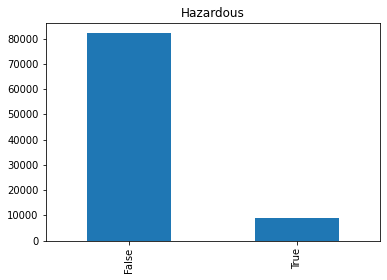

In [5]:
df.hazardous.value_counts().plot(kind='bar')
plt.title('Hazardous')
plt.show()

In [6]:
print("Summary of all numerical values :")
df.describe()

Summary of all numerical values :


,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


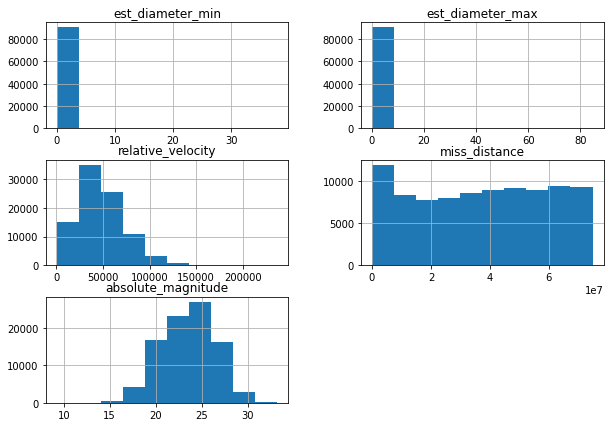

In [7]:
df.hist(bins=10, figsize=(10, 7))
pass

In [8]:
print("Visualization of categorical values :")
print(df.describe(include=["category", "bool"]))

Visualization of categorical values :
       orbiting_body sentry_object hazardous
count          90836         90836     90836
unique             1             1         2
top            Earth         False     False
freq           90836         90836     81996


As we can see we have only one `orbiting body` and only one value for the `sentry`. Those two columns can therefore be removed from the dataset safely.
The final column, the one we want to predict with the models, seems to have 10% of dangerous objects, the outliers we will try to identify.

In [9]:
df_stat = df.drop(columns=["sentry_object", "orbiting_body"])
pass

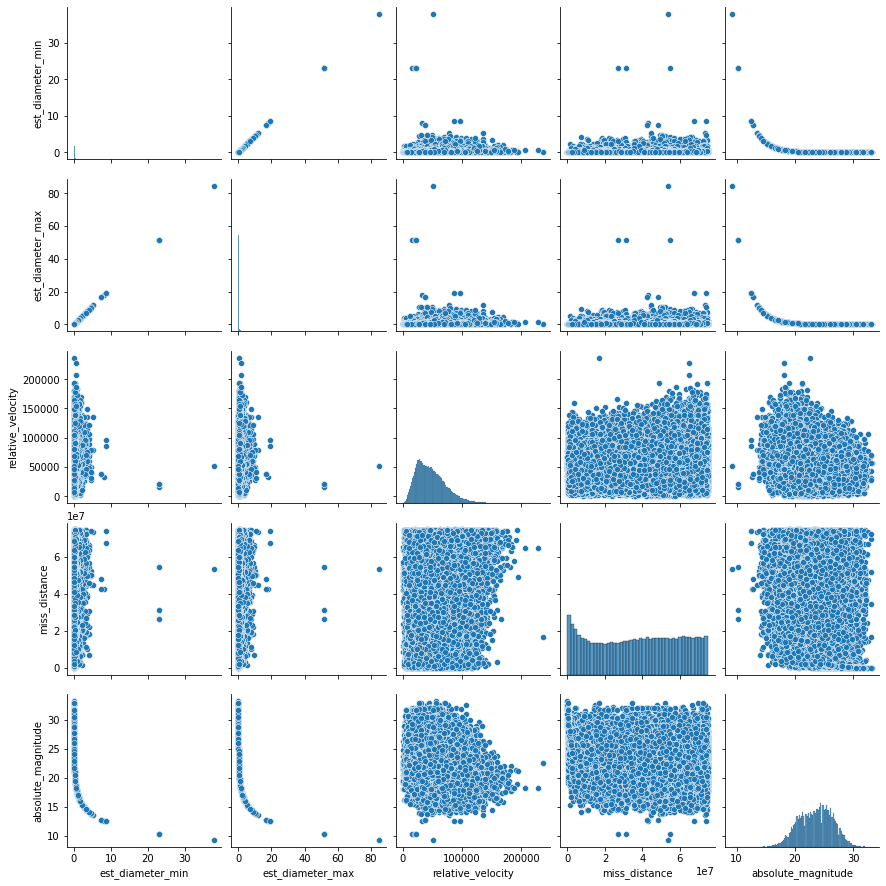

In [10]:
fig= sns.pairplot(df_stat[["est_diameter_min","est_diameter_max","relative_velocity","miss_distance","absolute_magnitude"]])

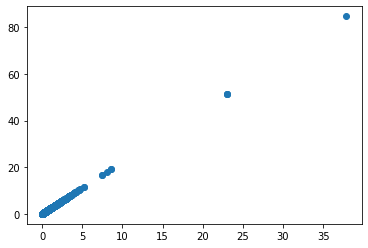

In [11]:
plt.scatter(df_stat.est_diameter_min, df.est_diameter_max)

We see that est_diameter_min and est_diamater_max are completly linearly correlated. We can therefore remove one.

In [12]:
df_stat = df.drop(['est_diameter_min'], axis=1)

In [13]:
df_stat

,id,name,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True
...,...,...,...,...,...,...,...,...,...
90831,3763337,(2016 VX1),0.059435,52078.886692,1.230039e+07,Earth,False,25.00,False
90832,3837603,(2019 AD3),0.037501,46114.605073,5.432121e+07,Earth,False,26.00,False
90833,54017201,(2020 JP3),0.071456,7566.807732,2.840077e+07,Earth,False,24.60,False
90834,54115824,(2021 CN5),0.016370,69199.154484,6.869206e+07,Earth,False,27.80,False


## Correlation

The correlation matrix of our data is the following:

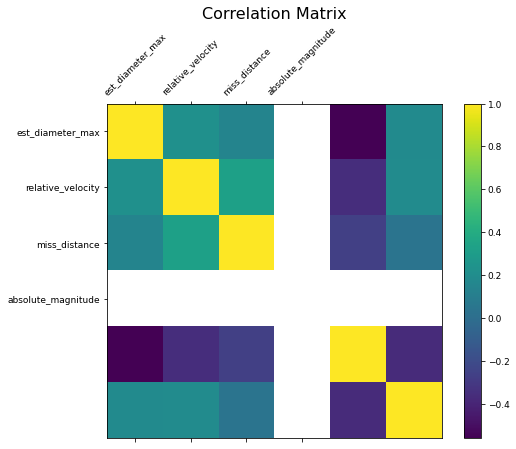

In [14]:
def dipslay_corr(df, corr):
    f = plt.figure(figsize=(8, 6))
    plt.matshow(corr, fignum=f.number)
    plt.xticks(
        range(df_stat.select_dtypes(["number"]).shape[1]),
        df_stat.select_dtypes(["number"]).columns,
        fontsize=9,
        rotation=45,
    )
    plt.yticks(
        range(df_stat.select_dtypes(["number"]).shape[1]),
        df_stat.select_dtypes(["number"]).columns,
        fontsize=9,
    )
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=9)
    plt.title("Correlation Matrix", fontsize=16)
    plt.show()


# Matrix de correlation
corr = df_stat.corr()
dipslay_corr(df_stat, corr)

In [15]:
df_stat

,id,name,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True
...,...,...,...,...,...,...,...,...,...
90831,3763337,(2016 VX1),0.059435,52078.886692,1.230039e+07,Earth,False,25.00,False
90832,3837603,(2019 AD3),0.037501,46114.605073,5.432121e+07,Earth,False,26.00,False
90833,54017201,(2020 JP3),0.071456,7566.807732,2.840077e+07,Earth,False,24.60,False
90834,54115824,(2021 CN5),0.016370,69199.154484,6.869206e+07,Earth,False,27.80,False


We can see in the matrix that the magnitude is negatively correlated with mos of the other variables. This implies that objects with a high magntiude, meaning not very visible objects, are usually smaller and slower. They also more importently do not consistute a threat seeing how the magnitude is negatively correlated with the hazardous.

When computing the correlation matrix only for the hazardous objects, we can see an even greater correlation between the magnitude and the size.

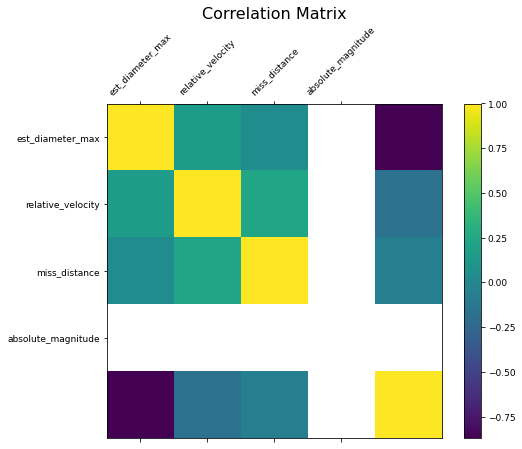

In [16]:
# Matrix de correlation
df_hazard_only = df_stat[df_stat["hazardous"] == True].drop(columns=["hazardous"])
corr_only_hazardous = df_hazard_only.corr()
dipslay_corr(df_hazard_only, corr_only_hazardous)

### Dimension Reduction

It seems some variables are more important than other. Let's see how much information we can keep while reducing the dimension.

In [17]:
X = df.drop(columns=["hazardous"])
Y = df["hazardous"]

In [18]:
X

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09
...,...,...,...,...,...,...,...,...,...
90831,3763337,(2016 VX1),0.026580,0.059435,52078.886692,1.230039e+07,Earth,False,25.00
90832,3837603,(2019 AD3),0.016771,0.037501,46114.605073,5.432121e+07,Earth,False,26.00
90833,54017201,(2020 JP3),0.031956,0.071456,7566.807732,2.840077e+07,Earth,False,24.60
90834,54115824,(2021 CN5),0.007321,0.016370,69199.154484,6.869206e+07,Earth,False,27.80


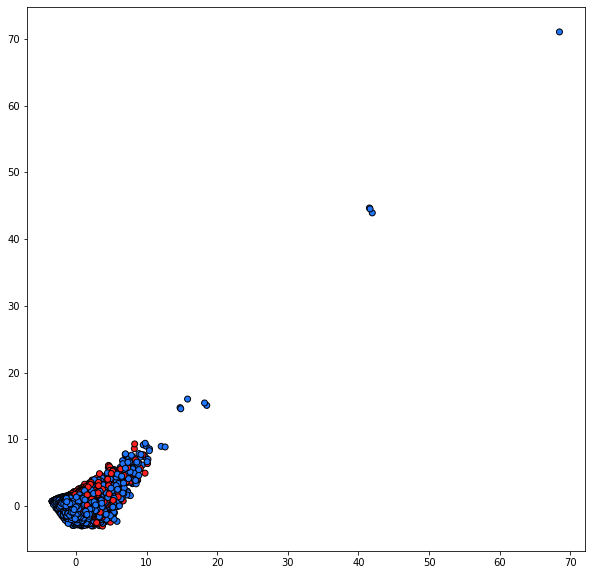

In [19]:
X = df[
    [
        "est_diameter_max",
        "relative_velocity",
        "miss_distance",
        "absolute_magnitude",
    ]
]
y = df["hazardous"]


# Scale the X
scaler = StandardScaler()
scaler.fit(X)
scaled = scaler.transform(X)

# Obtain principal components
pca = PCA().fit(scaled)

pc = pca.transform(scaled)
pc1 = pc[:, 0]
pc2 = pc[:, 1]

# Plot principal components
plt.figure(figsize=(10, 10))

colour = ["#ff2121" if e else "#2176ff" for e in y]
plt.scatter(pc1, pc2, c=colour, edgecolors="#000000")
plt.show()
pass

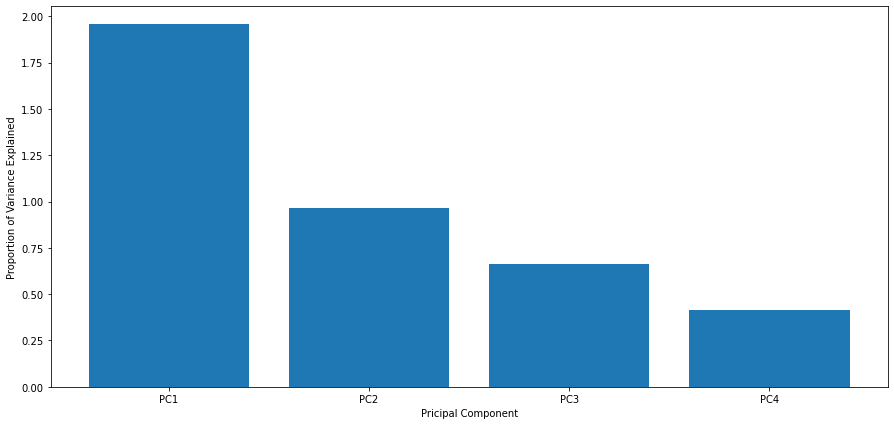

In [20]:
labels = ["PC1", "PC2", "PC3", "PC4"]

plt.figure(figsize=(15, 7))
plt.bar(labels, pca.explained_variance_)
plt.xlabel("Pricipal Component")
plt.ylabel("Proportion of Variance Explained")
plt.show()
pass

In [21]:
pca.explained_variance_ratio_

array([0.48894661, 0.24174391, 0.16526435, 0.10404514])

In [22]:
for i in range(len(pca.explained_variance_ratio_)):
	ratio = pca.explained_variance_ratio_[:i+1].sum() /pca.explained_variance_ratio_.sum() * 100
	print(f"{ratio}% variance explained for {i} axes")

48.89466053668151% variance explained for 0 axes
73.0690510554609% variance explained for 1 axes
89.59548566091323% variance explained for 2 axes
100.0% variance explained for 3 axes


We see that two axes are enough to explain 76% of the variance.

## 3D representation

We can also visualize multiple columns at once to see patterns.

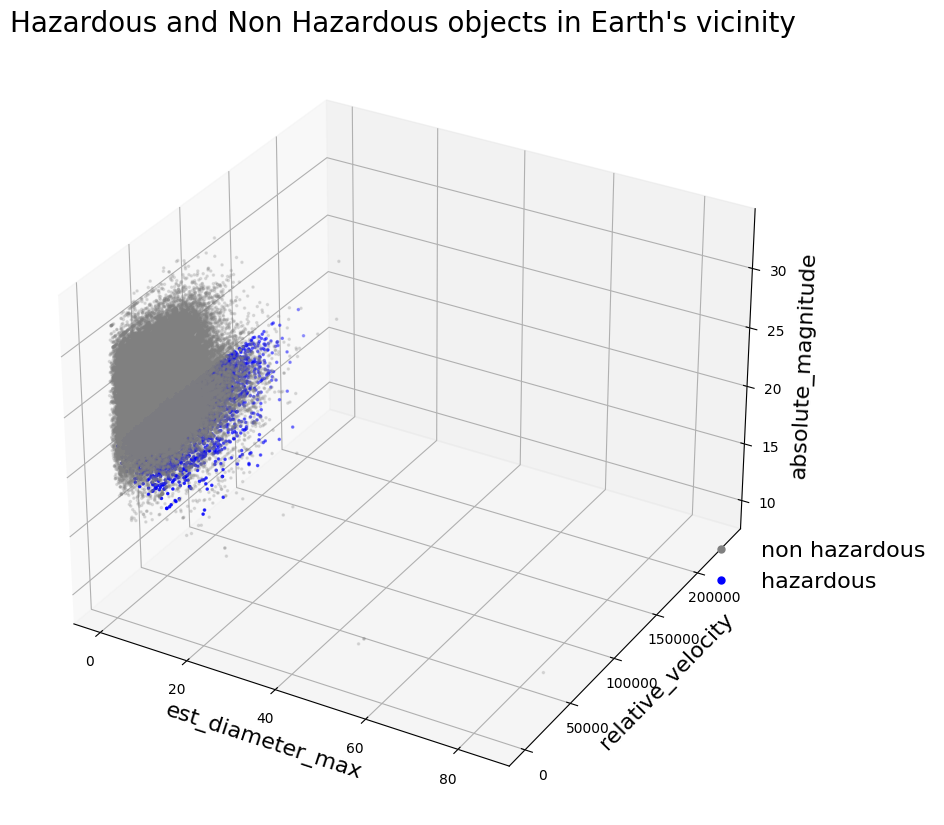

In [23]:
def show3D_data(df, x, y, z):
    """Show the data in 3d with three axis, the third one using log"""
    X = df.drop(columns=["hazardous"])
    Y = df["hazardous"]

    limit = len(X)

    sns.reset_orig()

    fig = plt.figure(figsize=(10, 12))
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(
        X.loc[Y == True, x][:limit],
        X.loc[Y == True, y][:limit],
        X.loc[Y == True, z][:limit],
        c="blue",
        marker=".",
        s=10,
        label="hazardous",
    )
    ax.scatter(
        X.loc[Y == False, x][:limit],
        X.loc[Y == False, y][:limit],
        X.loc[Y == False, z][:limit],
        c="gray",
        marker=".",
        s=10,
        label="non hazardous",
        alpha=0.2,
    )

    ax.set_xlabel(x, size=16)
    ax.set_ylabel(y, size=16)
    ax.set_zlabel(z, size=16)
    ax.set_title("Hazardous and Non Hazardous objects in Earth's vicinity", size=20)

    plt.axis("tight")
    ax.grid(1)

    normalMarker = mlines.Line2D(
        [],
        [],
        linewidth=0,
        color="gray",
        marker=".",
        markersize=10,
        label="non hazardous",
    )

    anomalyMarker = mlines.Line2D(
        [], [], linewidth=0, color="blue", marker=".", markersize=10, label="hazardous"
    )

    plt.legend(
        handles=[normalMarker, anomalyMarker],
        bbox_to_anchor=(1.20, 0.38),
        frameon=False,
        prop={"size": 16},
    )
    plt.show()


show3D_data(df_stat, "est_diameter_max", "relative_velocity", "absolute_magnitude")

Has can be seen on this first representation, the velocity seems to be slightly higher for objects considered a threat compared to the rest. The magnitude also seems to be capped at 20 for the hazardous objects, a high magnitude impliying a very dim object in the darkness of space.

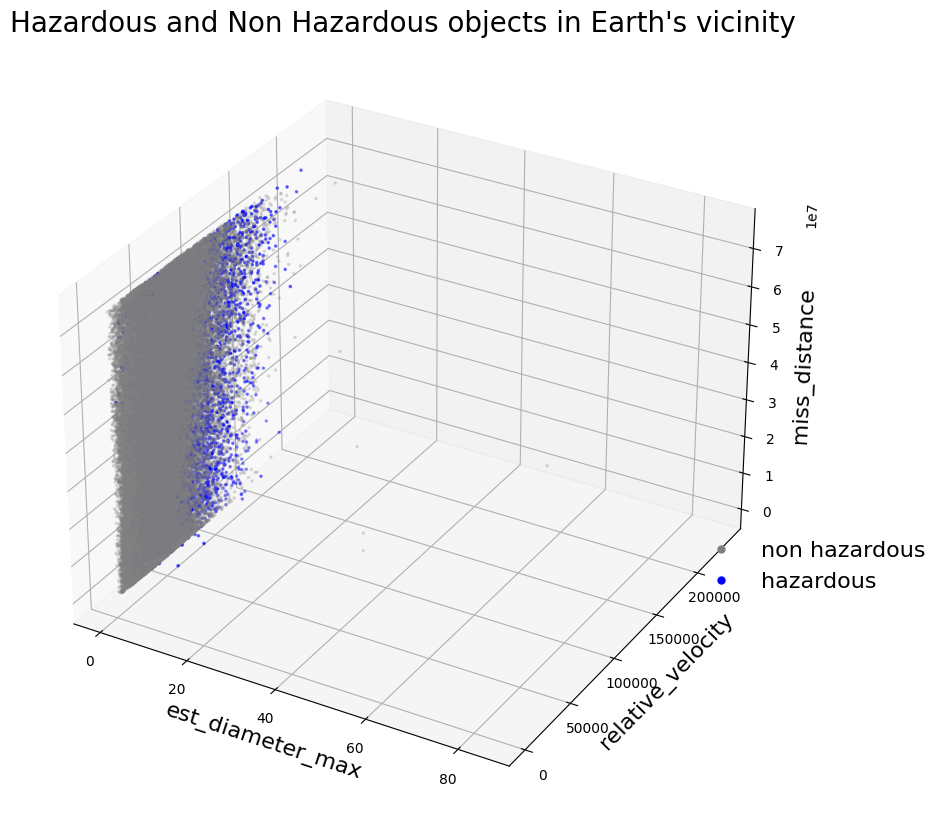

In [24]:
show3D_data(df_stat, "est_diameter_max", "relative_velocity", "miss_distance")

On this second graph we can further see that the velocity seems to be an important factor but on the other end the miss distance is not very representative. Indeed the miss distance is not that important considering objects could be shifted our of their orbit very easily by the cosmic billiard played in the solar system by gravity. An oibject that missed earth by a lot could still be a threat.

# Supervised Learning

First, we clean the dataset to get quantitative data to determine wether or not the object is considerer a potential threat by the nasa, it is this column we will want to monitor. We remove constant values (sentry_object=False and orbiting_body=Earth)

In [25]:
df_ml = df.drop(["name", "orbiting_body", "sentry_object"], axis=1)
df_ml = df_ml.set_index("id")
df_ml

/home/marius/epita/ING2/FTML_PTML/venv_ptml/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
id,,,,,,
2162635,1.198271,2.679415,13569.249224,5.483974e+07,16.73,False
2277475,0.265800,0.594347,73588.726663,6.143813e+07,20.00,True
2512244,0.722030,1.614507,114258.692129,4.979872e+07,17.83,False
3596030,0.096506,0.215794,24764.303138,2.543497e+07,22.20,False
3667127,0.255009,0.570217,42737.733765,4.627557e+07,20.09,True
...,...,...,...,...,...,...
3763337,0.026580,0.059435,52078.886692,1.230039e+07,25.00,False
3837603,0.016771,0.037501,46114.605073,5.432121e+07,26.00,False
54017201,0.031956,0.071456,7566.807732,2.840077e+07,24.60,False


## Initialize train and test sets

In [31]:
from sklearn.model_selection import train_test_split

X = df[
    [
        "est_diameter_max",
        "relative_velocity",
        "miss_distance",
        "absolute_magnitude",
    ]
]
y = df["hazardous"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

In [54]:
print(len(y_train))
y_train.to_frame().hazardous.value_counts()

60860


False    54969
True      5891
Name: hazardous, dtype: int64

In [53]:
(1 - 5891 / 54969) *100

89.28305044661536

The data has been analyzed and cleaned; now, its time to build those machine learning models.

The train set contains 60860 data instances and has 5891 cases labelled as 1(hazardous), which means that if a model predicts all values as 0, then the accuracy will be 89.28%. This will be considered as baseline accuracy for the train set.
Similarly, the baseline accuracy for the test set will be 89.08%.
Our model should do better than these accuracies or should be robust enough to deal with the class imbalance.

## Let's try multiple models

In [99]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    r2_score,
)
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


def try_model(model):
    print(f"=============== {model} ===============")
    model.fit(X_train, y_train)

    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)

    def print_metric(metric_name):
        print(f"------------ {metric_name} ------------")
        metric = metrics_dico[metric_name]
        print(f"train :\n{metric(y_train,y_train_predict)}")
        print(f"test :\n{metric(y_test,y_test_predict)}")

    metrics_dico = {
        "Classification Report": classification_report,
        "Accuracy Score": accuracy_score,
    }

    for metric_name in metrics_dico:
        print_metric(metric_name)

    conf_mat = confusion_matrix(y_test, y_test_predict, normalize='true')
    print(
        f"\n------------ Confusion matrix on test ------------\n{conf_mat}\n"
    )
    false_neg = conf_mat[1][0]
    false_pos = conf_mat[0][1]
    print(f"False negative : {false_neg}")
    print(f"False positive : {false_pos}")
    # plt.figure(figsize=(12, 12))
    sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="g")
    plt.show()

# fits PCA, transforms data and fits the decision tree classifier
# on the transformed data
pipe_tree = Pipeline(
    [
        # ('scale', StandardScaler()),
        ("pca", PCA(n_components=4)),
        ("tree", DecisionTreeClassifier()),
    ]
)

pipe_forest = Pipeline(
    [
        # ('scale', StandardScaler()), # scaling causes worse results
        ("pca", PCA(n_components=4)),
        ("tree", RandomForestClassifier(max_depth=3, random_state=0, n_estimators=50)),
    ]
)

models = [
    LogisticRegressionCV(class_weight="balanced"),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=0),
    pipe_tree,
    RandomForestClassifier(max_depth=3, random_state=0, n_estimators=50),
    pipe_forest
]

# for model in models:
#     try_model(model)

Let's start with a logistic reression.

=============== LogisticRegressionCV() ===============
------------ Classification Report ------------
train :
              precision    recall  f1-score   support

       False       0.90      1.00      0.95     54969
        True       0.00      0.00      0.00      5891

    accuracy                           0.90     60860
   macro avg       0.45      0.50      0.47     60860
weighted avg       0.82      0.90      0.86     60860

test :
              precision    recall  f1-score   support

       False       0.90      1.00      0.95     27027
        True       0.00      0.00      0.00      2949

    accuracy                           0.90     29976
   macro avg       0.45      0.50      0.47     29976
weighted avg       0.81      0.90      0.85     29976

------------ Accuracy Score ------------
train :
0.9032040749260598
test :
0.90162129703763

------------ Confusion matrix on test ------------
[[1. 0.]
 [1. 0.]]

False negative : 1.0
False positive : 0.0


/home/marius/epita/ING2/FTML_PTML/venv_ptml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marius/epita/ING2/FTML_PTML/venv_ptml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marius/epita/ING2/FTML_PTML/venv_ptml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

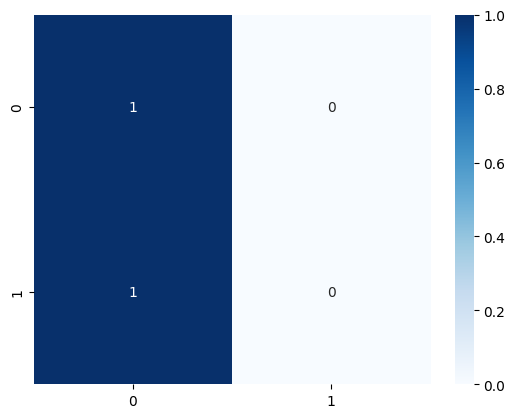

In [93]:
try_model(LogisticRegressionCV())

The confusion matrices clearly show that the model fails to predict even a single data instance as 1 (hazardous) and hence the model is not robust enough. 
We can ask the model to balance the data :

The “balanced” mode of the *class_weight* parameter uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as $n\_samples / (n\_classes * np.bincount(y))$

=============== LogisticRegressionCV(class_weight='balanced') ===============
------------ Classification Report ------------
train :
              precision    recall  f1-score   support

       False       0.94      0.38      0.54     54969
        True       0.12      0.76      0.20      5891

    accuracy                           0.41     60860
   macro avg       0.53      0.57      0.37     60860
weighted avg       0.86      0.41      0.50     60860

test :
              precision    recall  f1-score   support

       False       0.93      0.38      0.54     27027
        True       0.12      0.76      0.20      2949

    accuracy                           0.42     29976
   macro avg       0.53      0.57      0.37     29976
weighted avg       0.85      0.42      0.51     29976

------------ Accuracy Score ------------
train :
0.41390075583305946
test :
0.4150987456631972

------------ Confusion matrix on test ------------
[[0.37758538 0.62241462]
 [0.24109868 0.75890132]]

False 

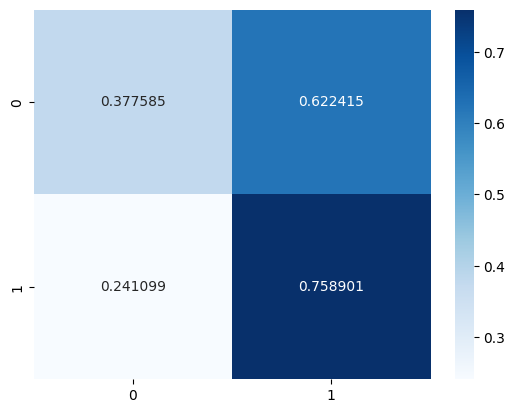

In [95]:
try_model(LogisticRegressionCV(class_weight='balanced'))

We observe really bad performances : the model achieves 42% accuracy, way below the 89% baseline accuracy.

Let's try another strategy : K neighbors

=============== KNeighborsClassifier() ===============
------------ Classification Report ------------
train :
              precision    recall  f1-score   support

       False       0.91      0.99      0.95     54969
        True       0.66      0.11      0.18      5891

    accuracy                           0.91     60860
   macro avg       0.79      0.55      0.57     60860
weighted avg       0.89      0.91      0.88     60860

test :
              precision    recall  f1-score   support

       False       0.90      0.99      0.94     27027
        True       0.21      0.03      0.06      2949

    accuracy                           0.89     29976
   macro avg       0.56      0.51      0.50     29976
weighted avg       0.83      0.89      0.86     29976

------------ Accuracy Score ------------
train :
0.9083470259612225
test :
0.8922471310381639

------------ Confusion matrix on test ------------
[[0.98590299 0.01409701]
 [0.9660902  0.0339098 ]]

False negative : 0.96609020006

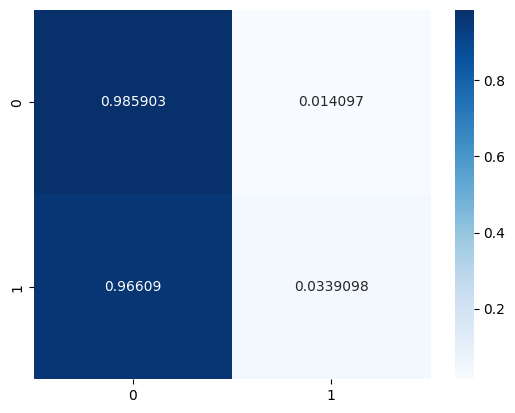

In [73]:
try_model(KNeighborsClassifier())

If we look at the table for Naive Bayes, then we see that the accuracies for the test set and train set are equal to baseline accuracies. Moreover, if we look at the confusion matrix, we remark that the model almost always classifies as negative, meaning the model is broken and has predicted all values as 0 (not hazardous). Such a model is of zero significance because there’s no point in using a model when it can never fulfil its purpose.

The results we observe are surely caused by the fact that the dataset is un balanced. Let's use another strategy : Decision tree and ensembling.

=============== DecisionTreeClassifier(random_state=0) ===============
------------ Classification Report ------------
train :
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     54969
        True       1.00      1.00      1.00      5891

    accuracy                           1.00     60860
   macro avg       1.00      1.00      1.00     60860
weighted avg       1.00      1.00      1.00     60860

test :
              precision    recall  f1-score   support

       False       0.94      0.94      0.94     27027
        True       0.44      0.45      0.45      2949

    accuracy                           0.89     29976
   macro avg       0.69      0.69      0.69     29976
weighted avg       0.89      0.89      0.89     29976

------------ Accuracy Score ------------
train :
1.0
test :
0.890245529757139

------------ Confusion matrix on test ------------
[[0.93843194 0.06156806]
 [0.55137335 0.44862665]]

False negative : 0.55137334689

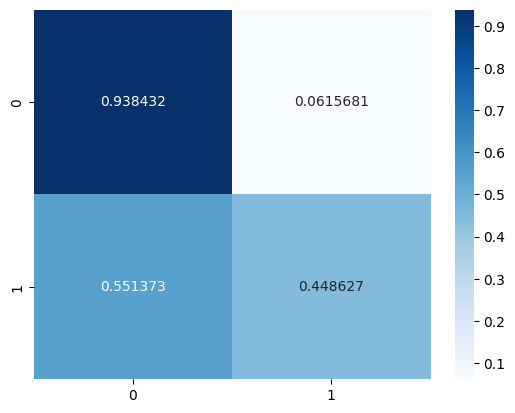

In [74]:
try_model(DecisionTreeClassifier(random_state=0))

The accuracy for the test dataset remains equal to the baseline accuracy, but we can see that the accuracy of the train set is perfect ; the tree has overfit. To avoid that, we can choose a maximul depth.

=============== DecisionTreeClassifier(max_depth=3, random_state=0) ===============
------------ Classification Report ------------
train :
              precision    recall  f1-score   support

       False       0.91      1.00      0.95     54969
        True       0.85      0.13      0.23      5891

    accuracy                           0.91     60860
   macro avg       0.88      0.56      0.59     60860
weighted avg       0.91      0.91      0.88     60860

test :
              precision    recall  f1-score   support

       False       0.91      1.00      0.95     27027
        True       0.83      0.12      0.20      2949

    accuracy                           0.91     29976
   macro avg       0.87      0.56      0.58     29976
weighted avg       0.90      0.91      0.88     29976

------------ Accuracy Score ------------
train :
0.9135228393033191
test :
0.9105951427808914

------------ Confusion matrix on test ------------
[[0.997336   0.002664  ]
 [0.88436758 0.11563242]]

F

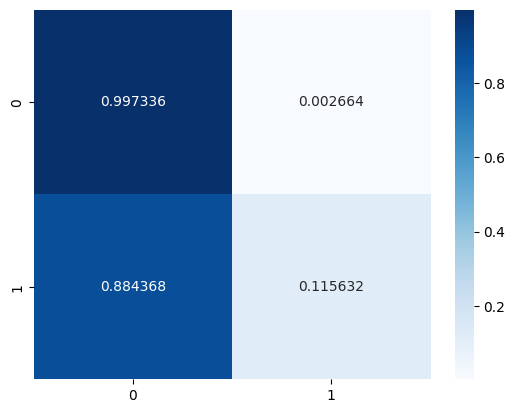

In [86]:
try_model(DecisionTreeClassifier(random_state=0, max_depth=3))

We now have a test accuracy of 91, which is better than the baseline accuracy. An other way to avoid overfit is **bagging**.

#### Bagging

The principle of bagging is to choose **n** random subsets from the training set, and train **n** decision trees on it.
For each candidate in the test set, Random Forest uses the class with the majority vote as this candidate’s final prediction.

=============== RandomForestClassifier(max_depth=3, n_estimators=50, random_state=0) ===============
------------ Classification Report ------------
train :
              precision    recall  f1-score   support

       False       0.91      1.00      0.95     54969
        True       0.85      0.13      0.22      5891

    accuracy                           0.91     60860
   macro avg       0.88      0.56      0.59     60860
weighted avg       0.91      0.91      0.88     60860

test :
              precision    recall  f1-score   support

       False       0.91      1.00      0.95     27027
        True       0.83      0.11      0.20      2949

    accuracy                           0.91     29976
   macro avg       0.87      0.56      0.58     29976
weighted avg       0.90      0.91      0.88     29976

------------ Accuracy Score ------------
train :
0.9135721327637201
test :
0.9106285028022418

------------ Confusion matrix on test ------------
[[0.997447   0.002553  ]
 [0.8850457

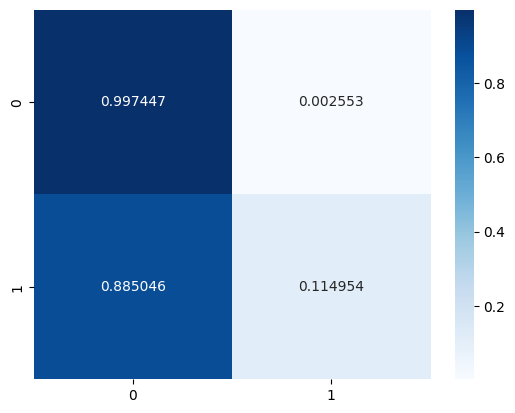

In [92]:
try_model(RandomForestClassifier(max_depth=3, random_state=0, n_estimators=50))

It improves the result only by 0.005% . Let's try another strategy, **Boosting**

#### Boosting

Boosting model’s key is learning from the previous mistakes, e.g. misclassification data points. **n** estimators are trained sequentially ; they are trained with the residual errors of the previous tree, and the final prediction is made by simply adding up the predictions (of all trees).

=============== GradientBoostingClassifier(n_estimators=50) ===============
------------ Classification Report ------------
train :
              precision    recall  f1-score   support

       False       0.92      1.00      0.95     54969
        True       0.81      0.14      0.24      5891

    accuracy                           0.91     60860
   macro avg       0.87      0.57      0.60     60860
weighted avg       0.91      0.91      0.89     60860

test :
              precision    recall  f1-score   support

       False       0.91      1.00      0.95     27027
        True       0.79      0.13      0.22      2949

    accuracy                           0.91     29976
   macro avg       0.85      0.56      0.59     29976
weighted avg       0.90      0.91      0.88     29976

------------ Accuracy Score ------------
train :
0.9139336181399934
test :
0.9108620229516947

------------ Confusion matrix on test ------------
[[0.996411   0.003589  ]
 [0.87317735 0.12682265]]

False neg

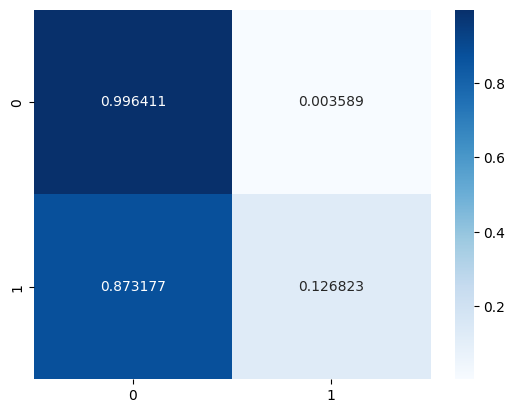

In [108]:
try_model(GradientBoostingClassifier(n_estimators=50))

We improved the result by 0.04 %. We can improve the accuracy further by increasing the number of estimators :

=============== GradientBoostingClassifier(n_estimators=500) ===============
------------ Classification Report ------------
train :
              precision    recall  f1-score   support

       False       0.93      0.99      0.96     54969
        True       0.83      0.26      0.40      5891

    accuracy                           0.92     60860
   macro avg       0.88      0.63      0.68     60860
weighted avg       0.92      0.92      0.90     60860

test :
              precision    recall  f1-score   support

       False       0.92      0.99      0.95     27027
        True       0.75      0.21      0.32      2949

    accuracy                           0.92     29976
   macro avg       0.83      0.60      0.64     29976
weighted avg       0.90      0.92      0.89     29976

------------ Accuracy Score ------------
train :
0.9233815313835031
test :
0.9150320256204963

------------ Confusion matrix on test ------------
[[0.99234099 0.00765901]
 [0.79348932 0.20651068]]

False ne

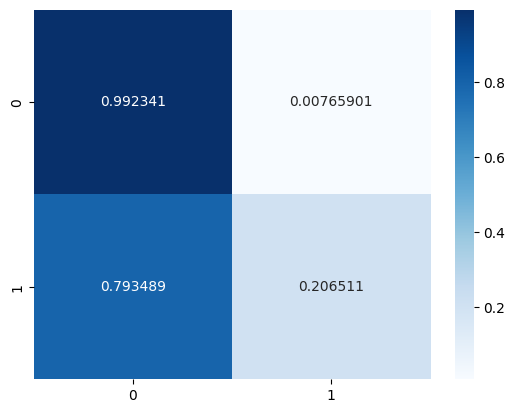

In [107]:
try_model(GradientBoostingClassifier(n_estimators=500))

### Dimension Reduction to facilitate classification

In [28]:
# fits PCA, transforms data and fits the decision tree classifier
# on the transformed data
pipe_tree = Pipeline(
    [
        # ('scale', StandardScaler()),
        ("pca", PCA(n_components=3)),
        ("tree", DecisionTreeClassifier()),
    ]
)

pipe_forest = Pipeline(
    [
        # ('scale', StandardScaler()), # scaling causes worse results
        ("pca", PCA(n_components=3)),
        ("tree", RandomForestClassifier(max_depth=3, random_state=0, n_estimators=50)),
    ]
)

pipe_tree.fit(X_train, y_train)
y_pred_tree = pipe_tree.predict(X_test)

dec_tree_score_train = pipe_tree.score(X_train, y_train)
dec_tree_score_test = pipe_tree.score(X_test, y_test)
print(f"Score on training set : {dec_tree_score_train}")
print(f"Score on test set : {dec_tree_score_test}\n")


pipe_forest.fit(X_train, y_train)
y_pred_forest = pipe_forest.predict(X_test)

rand_forest_score_train = pipe_forest.score(X_train, y_train)
rand_forest_score_test = pipe_forest.score(X_test, y_test)
print(f"Score on training set : {rand_forest_score_train}")
print(f"Score on test set : {rand_forest_score_test}\n")

Score on training set : 1.0
Score on test set : 0.8798705631171604

Score on training set : 0.9034341110745975
Score on test set : 0.9017213771016813



[[25193  1834]
 [ 1767  1182]]
False negative : 1767
False positive : 1834


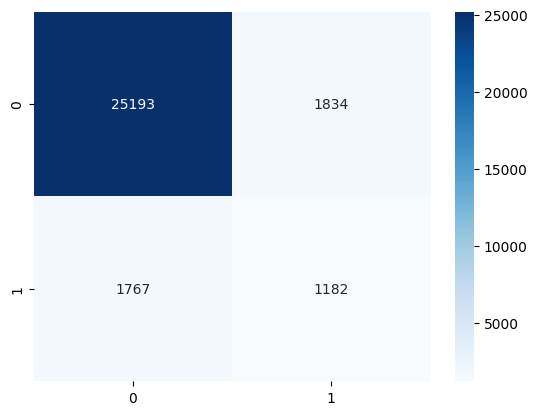

In [29]:
conf_mat = confusion_matrix(y_test, y_pred_tree)
print(conf_mat)
false_neg = conf_mat[1][0]
false_pos = conf_mat[0][1]
print(f"False negative : {false_neg}")
print(f"False positive : {false_pos}")
# plt.figure(figsize=(12, 12))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="g")
plt.show()
pass

[[27027     0]
 [ 2946     3]]
False negative : 2946
False positive : 0


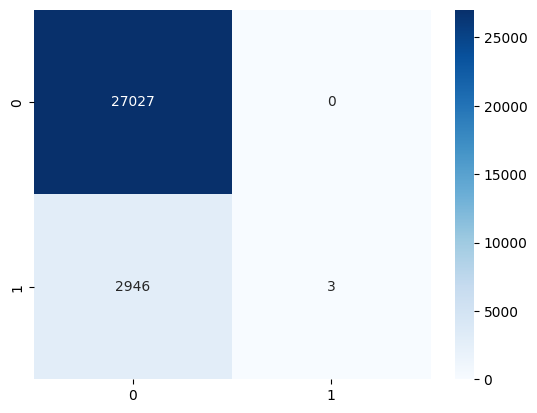

In [30]:
conf_mat = confusion_matrix(y_test, y_pred_forest)
print(conf_mat)
false_neg = conf_mat[1][0]
false_pos = conf_mat[0][1]
print(f"False negative : {false_neg}")
print(f"False positive : {false_pos}")

# plt.figure(figsize=(12, 12))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="g")
plt.show()